# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

##### &#9658; [View table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import copy

In [3]:
import torch.nn
import torch.optim
import torch.utils.data

## Outline

Define a family of 1D functions to encode, derived from a Gaussian process prior.

Start with a 1-1 architecture, then experiment with:
 - reducing the latent-space dimension
 - overfit few examples to check network expressiveness
 - adding input noise (then including ivar in L2 loss)
 - number of layers
 - dense vs convolutional
 - different internal and output-layer activations
 - dropout
 
Try generative models following these examples: https://github.com/znxlwm/pytorch-generative-model-collections

Try probabilistic models following these examples: https://github.com/ericjang/normalizing-flows-tutorial

### Gaussian Process Function Prior

Define squared-exponential covariance
$$
K(x, x') = \sigma_0^2 \exp\left[ -\frac{1}{2}\left( \frac{x - x'}{\lambda}\right)^2\right] \; ,
$$
which is *stationary*, i.e., translation invariant since $K(x + x_0, x' + x_0) = K(x, x')$.

In [4]:
def gpsample(x, sig0, lam, ngen=1, gen=None):
    
    # Tabulate K for each pair of elements in x.
    xT = x.reshape(-1, 1)
    K = sig0 ** 2 * np.exp(-0.5 * ((xT - x) / lam) ** 2)

    # Generate random samples of f(x).
    if not isinstance(gen, np.random.RandomState):
        gen = np.random.RandomState(gen)
    mu = np.zeros_like(x)
    return gen.multivariate_normal(mu, K, size=ngen)

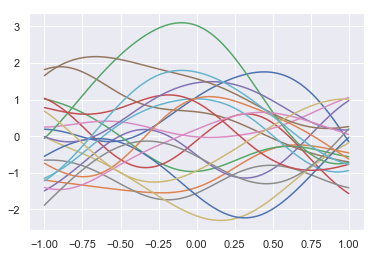

In [295]:
x = np.linspace(-1, 1, 64)
fx = gpsample(x, sig0=1.0, lam=0.5, ngen=20, gen=123)
plt.plot(x, fx.T, '-');

### PyTorch Train and Test Data

In [298]:
sig0, lam = 1.0, 0.5
x = np.linspace(-1, 1, 64)
gen = np.random.RandomState(seed=123)
X_train = gpsample(x, sig0, lam, ngen=20000, gen=gen)
X_test = gpsample(x, sig0, lam, ngen=20000, gen=gen)
np.array_equal(X_train, X_test)

False

0.0010638537700979594 0.9986993083244192


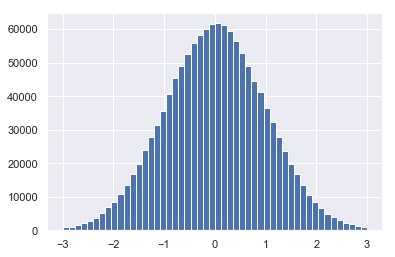

In [301]:
plt.hist(X_train.reshape(-1), range=(-3, 3), bins=50);
print(np.mean(X_train), np.std(X_train))

### Autoencoder

First define a simple pass-through network:

In [302]:
class PassThrough(torch.nn.Module):
    
    def __init__(self, n_input):
        super(PassThrough, self).__init__()
        self.output = torch.nn.Linear(n_input, n_input)
        
    def forward(self, fx_in):
        return self.output(fx_in)

In [303]:
def get_lr(self, name='lr'):
    lr_grps = [grp for grp in self.param_groups if name in grp]
    if not lr_grps:
        raise ValueError(f'Optimizer has no parameter called "{name}".')
    if len(lr_grps) > 1:
        raise ValueError(f'Optimizer has multiple parameters called "{name}".')
    return lr_grps[0][name]

def set_lr(self, value, name='lr'):
    lr_grps = [grp for grp in self.param_groups if name in grp]
    if not lr_grps:
        raise ValueError(f'Optimizer has no parameter called "{name}".')
    if len(lr_grps) > 1:
        raise ValueError(f'Optimizer has multiple parameters called "{name}".')
    lr_grps[0][name] = value    

torch.optim.Optimizer.get_lr = get_lr
torch.optim.Optimizer.set_lr = set_lr

In [304]:
def get_nparams(self):
    return np.sum([np.prod(p.size()) for p in self.parameters()])

torch.nn.Module.get_nparams = get_nparams

In [318]:
class ActivationWatcher(object):
    def __init__(self, name):
        self.name = name
        self.last = None
        print(f'registered {name}')
    def __call__(self, module, inputs, outputs):
        #print(self.name, inputs[0].size())
        if not module.training:
            return
        if self.last is not None:
            self.delta = inputs[0] - self.last
        self.last = inputs[0]

def unwatch_activations(self):
    if hasattr(self, 'activation_hooks'):
        for hook in self.activation_hooks:
            hook.remove()
    self.activation_hooks = []
    self.activation_watchers = []

def watch_activations(self, watch_inputs=True):
    self.unwatch_activations()
    for name, module in self.named_modules():
        if len(list(module.parameters())):
            continue
        # Module has no parameters so assume it is an activation.
        watcher = ActivationWatcher(name)
        self.activation_watchers.append(watcher)
        self.activation_hooks.append(module.register_forward_hook(watcher))
    if watch_inputs:
        watcher = ActivationWatcher('input')
        self.activation_watchers.append(watcher)
        self.activation_hooks.append(self.register_forward_hook(watcher))
        
def plot_activations(self):
    if not hasattr(self, 'activation_watchers'):
        raise RuntimeError('No activation hooks registered.')
    for watcher in self.activation_watchers:
        if watcher.last is not None:
            plt.scatter(watcher.last.detach().numpy(), watcher.delta.detach().numpy(), lw=0, label=watcher.name)
        plt.legend()
        plt.show()
        
torch.nn.Module.unwatch_activations = unwatch_activations
torch.nn.Module.watch_activations = watch_activations
torch.nn.Module.plot_activations = plot_activations

In [313]:
def lr_scan(loader, model, loss, optimizer_class=torch.optim.SGD, lr_start=1e-6, lr_stop=1.):
    # See https://github.com/fastai/fastai/blob/master/fastai/callbacks/lr_finder.py
    # and https://medium.com/coinmonks/training-neural-networks-upto-10x-faster-3246d84caacd

    # Save the model state before scanning.
    model_save = copy.deepcopy(model.state_dict())
    # Instantiate the optimizer.
    if isinstance(optimizer_class, torch.optim.Optimizer):
        optimizer_class = optimizer_class.__class__
    optimizer = optimizer_class(model.parameters(), lr=1.)
    assert optimizer.get_lr() == 1.
    # Schedule learning rate to increase in logarithmic steps over the epoch.
    lr_schedule = np.logspace(np.log10(lr_start), np.log10(lr_stop), len(loader))
    model.train()
    losses = []
    for cycle, (lr, batch) in enumerate(zip(lr_schedule, loader)):
        fx_in = batch[0]
        # Calculate outputs for this batch of inputs.
        fx_out = model(fx_in)
        # Measure how well the outputs match the inputs.
        loss_value = loss(fx_out, fx_in)
        losses.append(float(loss_value))
        # Bail out if this is much worse than the initial loss.
        if losses[-1] > 10 * losses[0]:
            print(f'Bailing out at lr={lr:.3g} after {cycle+1} batches.')
            break
        # Set learning rate for this batch.
        optimizer.set_lr(lr)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    # Restore the model state.
    model.load_state_dict(model_save)
    # Plot the scan results.
    plt.plot(lr_schedule[:cycle + 1], losses, '.')
    plt.ylim(0.5 * np.min(losses), 10 * losses[0])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    # Return an optimizer with set_lr/get_lr methods, and lr set to half of the best value found.
    idx = np.argmin(losses)
    lr_set = 0.5 * lr_schedule[idx]
    print(f'Recommended lr={lr_set:.3g}.')
    return optimizer_class(model.parameters(), lr=lr_set)

In [306]:
def train_model(loader, model, loss, optimizer, n_epochs, n_plot=2, test_data=None, report_interval=1, watch=True):
    n_samples = len(loader.dataset)
    n_batch = loader.batch_size
    n_params = np.sum([np.prod(p.size()) for p in model.parameters()])
    print(f'Training model with {n_params} params over {n_epochs} epochs of {n_samples} samples with batch size {n_batch}.')
    # Put the model in "train" mode.
    model.train()
    if watch:
        model.watch_activations()
    # Loop over training epochs.
    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        # --- Loop over batches in this epoch ----------------------------------
        for batch in loader:
            fx_in = batch[0]
            # Calculate outputs for this batch of inputs.
            fx_out = model(fx_in)
            # Measure how well the outputs match the inputs.
            loss_value = loss(fx_out, fx_in)
            # Adjust the model parameters for better matches.
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
        # --- Periodic progress report -----------------------------------------
        train_losses.append(loss_value.data)
        msg = f'Loss after {epoch + 1} epochs: {train_losses[-1]:.3g} (TRAIN)'
        reporting = ((epoch + 1) % report_interval == 0)
        if watch and reporting:
            model.plot_activations()
        if n_plot and reporting:
            for i in range(n_plot):
                P = plt.plot(fx_in[i].detach().numpy(), '-', lw=3, alpha=0.5)
                plt.plot(fx_out[i].detach().numpy(), '.', c=P[-1].get_color())
        if test_data is not None:
            model.eval()
            fx_in = test_data
            fx_out = model(fx_in)
            loss_value = loss(fx_out, fx_in)
            test_losses.append(loss_value.data)
            msg += f' {test_losses[-1]:.3g} (TEST)'
            model.train()
            if n_plot and reporting:
                for i in range(n_plot):
                    P = plt.plot(fx_in[i].detach().numpy(), '--')
                    plt.plot(fx_out[i].detach().numpy(), '+', c=P[-1].get_color())
        if reporting:
            print(msg)
            if n_plot:
                plt.show()            
    if watch:
        model.unwatch_activations()

    plt.plot(train_losses, '.', label='TRAIN')
    if test_data is not None:
        plt.plot(test_losses, '+', label='TEST')
    plt.legend()
    plt.yscale('log')

    return train_losses, test_losses

In [197]:
def plot_some(module, inputs, outputs, n=3):
    for fx_in, fx_out in zip(inputs[0][:n].numpy(), outputs[:n].detach().numpy()):
        P = plt.plot(fx_in, '-')
        plt.plot(fx_out, '.', c=P[-1].get_color())
    plt.show()

In [319]:
torch.manual_seed(123)
data = torch.utils.data.TensorDataset(torch.Tensor(X_train))
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, drop_last=True)
loss = torch.nn.MSELoss()
model = PassThrough(len(x))

Bailing out at lr=3.64 after 139 batches.
Recommended lr=1.07.


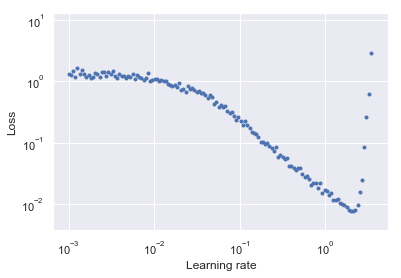

In [320]:
optimizer = lr_scan(loader, model, loss, torch.optim.SGD, lr_start=1e-3, lr_stop=10)

Training model with 4160 params over 5 epochs of 20000 samples with batch size 128.
registered input


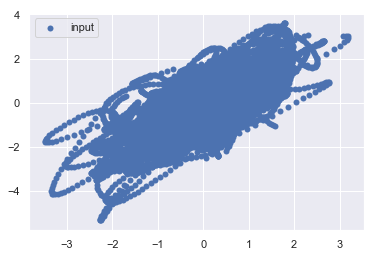

Loss after 1 epochs: 0.00124 (TRAIN) 0.00116 (TEST)


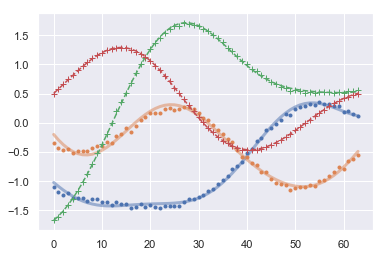

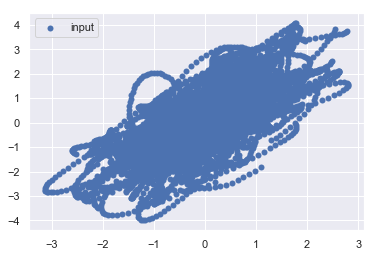

Loss after 2 epochs: 0.000585 (TRAIN) 0.000549 (TEST)


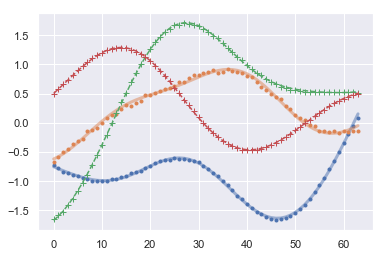

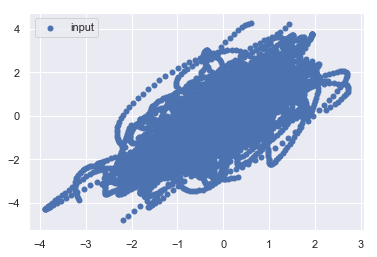

Loss after 3 epochs: 0.000348 (TRAIN) 0.000366 (TEST)


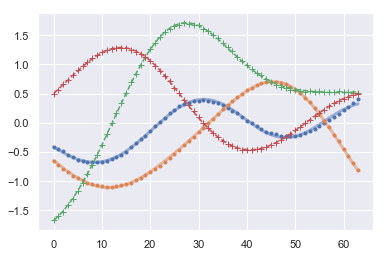

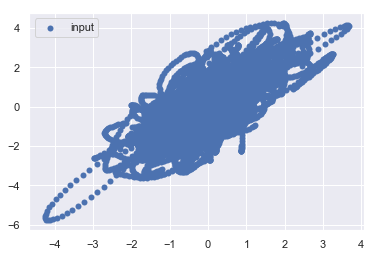

Loss after 4 epochs: 0.000252 (TRAIN) 0.000277 (TEST)


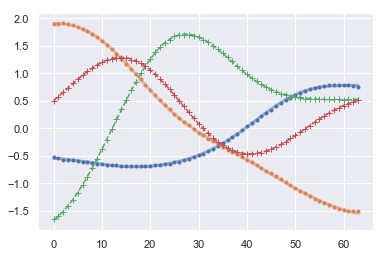

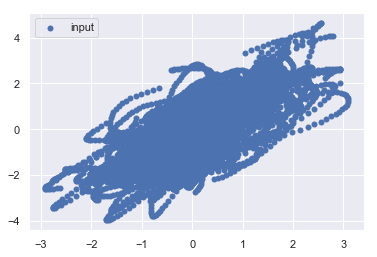

Loss after 5 epochs: 0.000218 (TRAIN) 0.000225 (TEST)


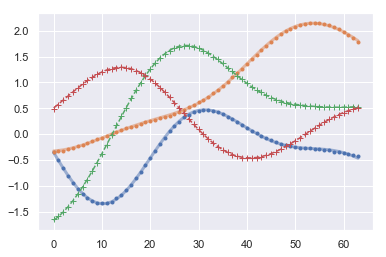

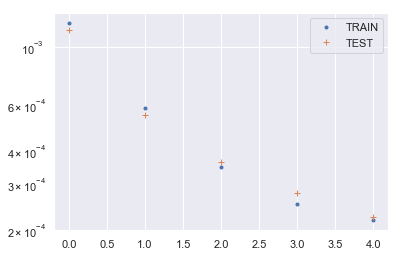

In [321]:
train_losses, test_losses = train_model(loader, model, loss, optimizer, n_epochs=5, test_data=torch.Tensor(X_test))

In [322]:
W = model.output.weight.detach().numpy()
b = model.output.bias.detach().numpy()

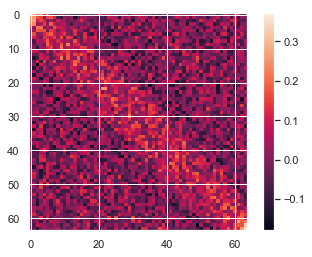

In [323]:
plt.imshow(W, interpolation='none')
plt.colorbar();

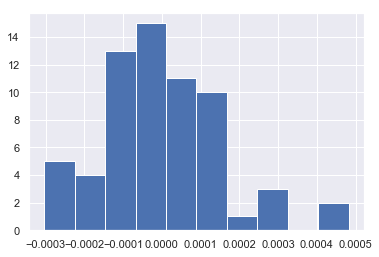

In [324]:
plt.hist(b);

In this example, our model is entirely linear and we can express the learning problem as:
$$
X = X W + \mathbf{b}
$$
which is trivially solved with $W = \mathbb{1}$ and $\mathbf{b} = 0$. When the number of samples $N$ in $X$ is larger than the number of features $D$, then the problem is formally over constrained, but the iterative (and stochastic) optimization will still find an approximate "best fit".

In [325]:
class EncodeDecode(torch.nn.Module):
    
    def __init__(self, n_node, activation=torch.nn.ReLU):
        super(EncodeDecode, self).__init__()
        n_layer = len(n_node) - 1
        encoder_layers, decoder_layers = [], []
        for lyr in range(n_layer):
            encoder_layers.append(torch.nn.Linear(n_node[lyr], n_node[lyr + 1]))
            encoder_layers.append(activation())
            if lyr > 0:
                decoder_layers.append(activation())
            decoder_layers.append(torch.nn.Linear(n_node[lyr + 1], n_node[lyr]))
        self.encoder = torch.nn.Sequential(*encoder_layers)
        self.decoder = torch.nn.Sequential(*decoder_layers[::-1])
        
    def forward(self, fx_in):
        return self.decoder(self.encoder(fx_in))

In [352]:
print(EncodeDecode([64, 16], activation=torch.nn.Tanh))

EncodeDecode(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
  )
)


Bailing out at lr=2.71 after 134 batches.
Recommended lr=0.947.


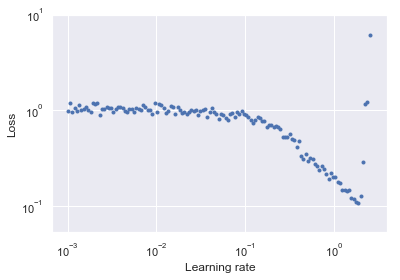

In [328]:
torch.manual_seed(123)
model = EncodeDecode([64, 16])
optimizer = lr_scan(loader, model, loss, lr_start=1e-3, lr_stop=10)

registered encoder.1
registered input
Training model with 2128 params over 10 epochs of 20000 samples with batch size 128.
registered encoder.1
registered input


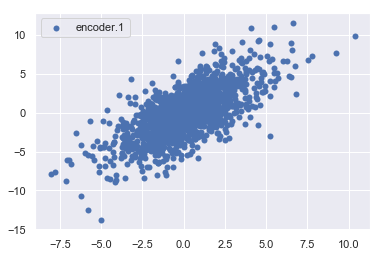

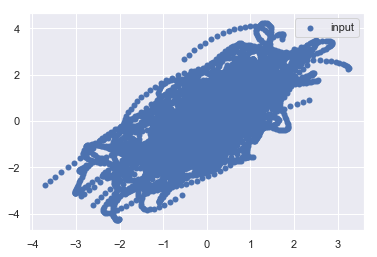

Loss after 1 epochs: 0.0188 (TRAIN) 0.0181 (TEST)


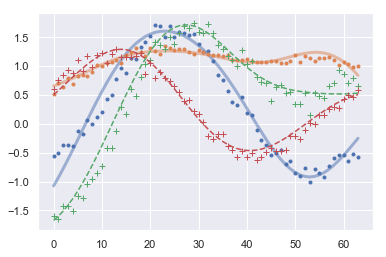

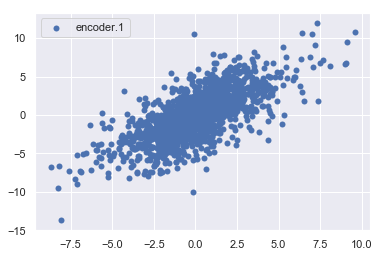

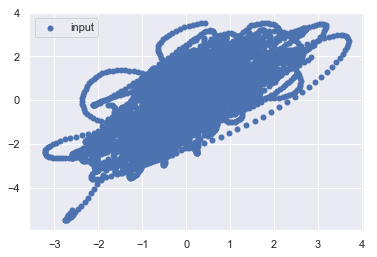

Loss after 2 epochs: 0.00957 (TRAIN) 0.00949 (TEST)


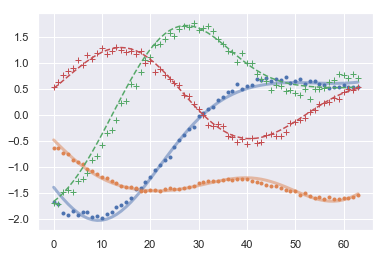

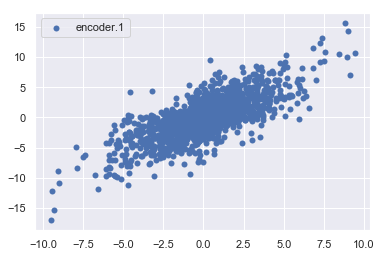

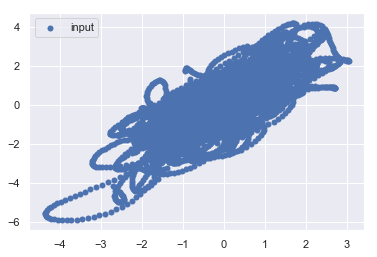

Loss after 3 epochs: 0.00722 (TRAIN) 0.00782 (TEST)


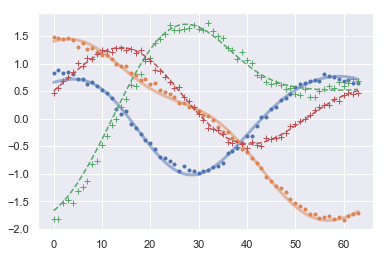

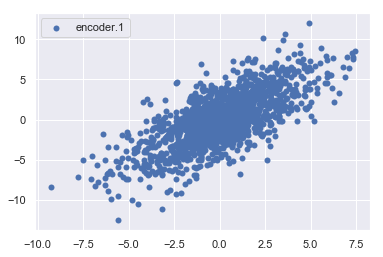

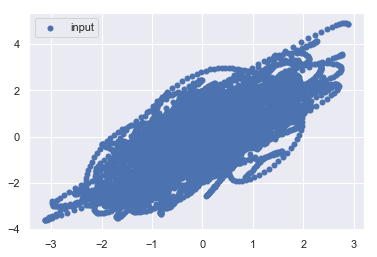

Loss after 4 epochs: 0.00386 (TRAIN) 0.00451 (TEST)


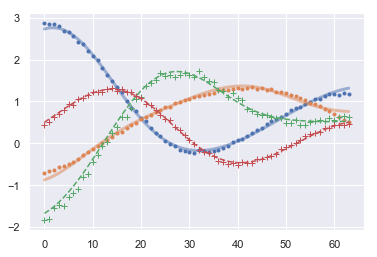

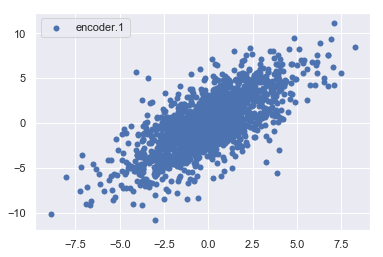

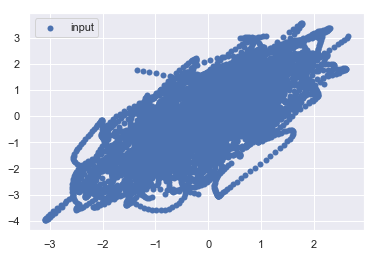

Loss after 5 epochs: 0.00305 (TRAIN) 0.00307 (TEST)


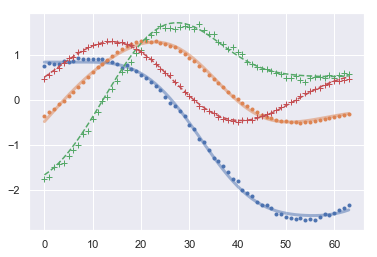

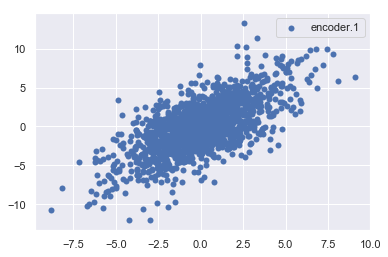

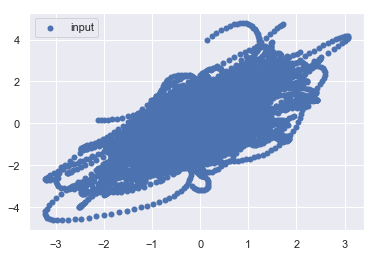

Loss after 6 epochs: 0.00297 (TRAIN) 0.00267 (TEST)


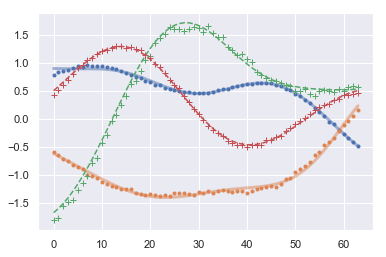

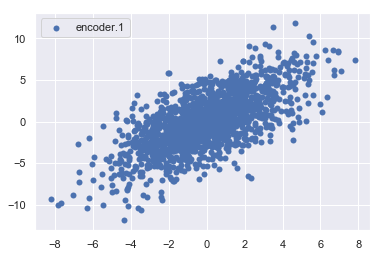

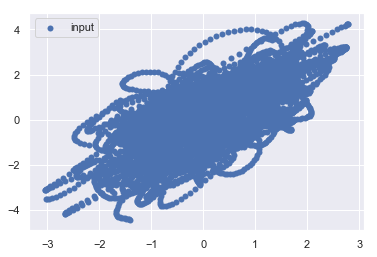

Loss after 7 epochs: 0.0023 (TRAIN) 0.0024 (TEST)


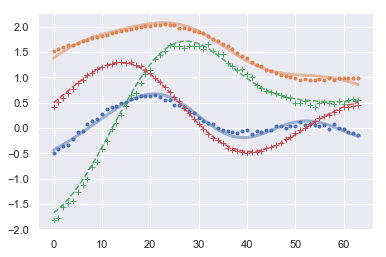

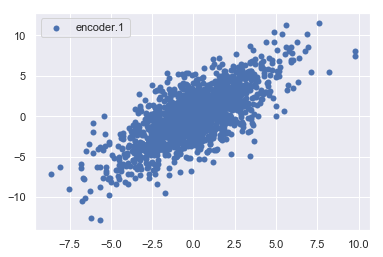

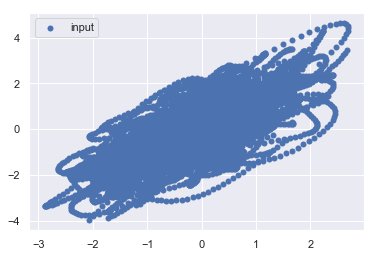

Loss after 8 epochs: 0.00183 (TRAIN) 0.00195 (TEST)


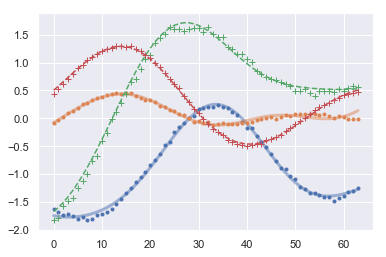

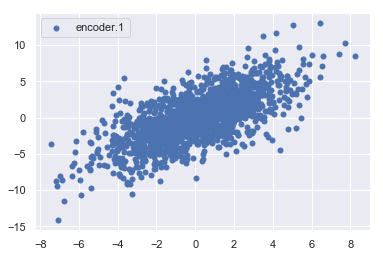

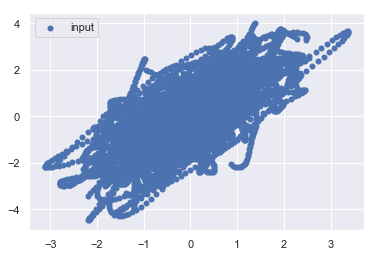

Loss after 9 epochs: 0.00213 (TRAIN) 0.00206 (TEST)


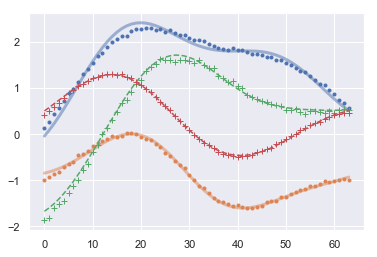

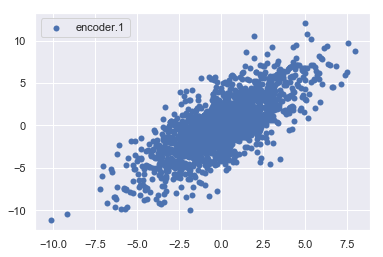

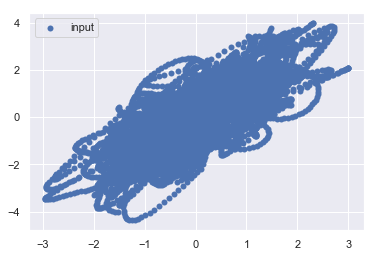

Loss after 10 epochs: 0.00141 (TRAIN) 0.00132 (TEST)


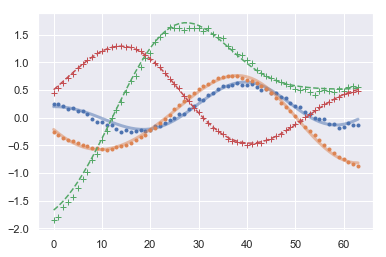

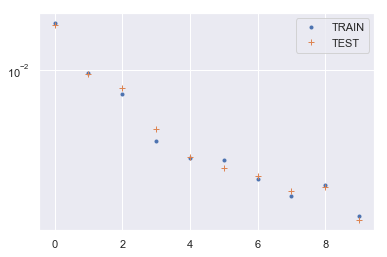

In [329]:
torch.manual_seed(123)
model.watch_activations()
train_losses, test_losses = train_model(
    loader, model, loss, optimizer, n_epochs=10, test_data=torch.Tensor(X_test))

Bailing out at lr=2.55 after 133 batches.
Recommended lr=0.589.


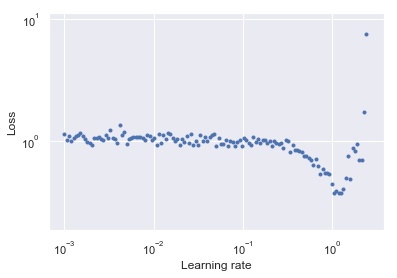

In [342]:
torch.manual_seed(123)
model = EncodeDecode([64, 8])
optimizer = lr_scan(loader, model, loss, lr_start=1e-3, lr_stop=10)

Training model with 1096 params over 100 epochs of 20000 samples with batch size 128.
registered encoder.1
registered input


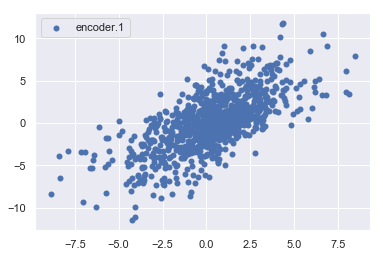

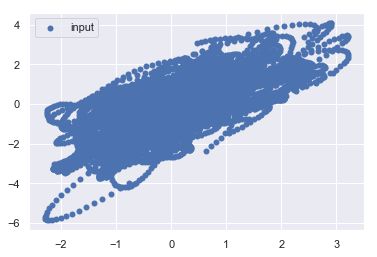

Loss after 20 epochs: 0.00232 (TRAIN) 0.00308 (TEST)


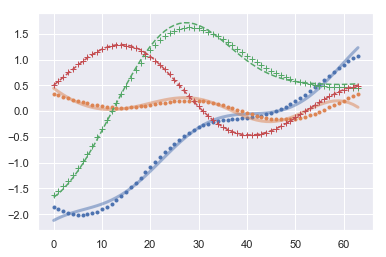

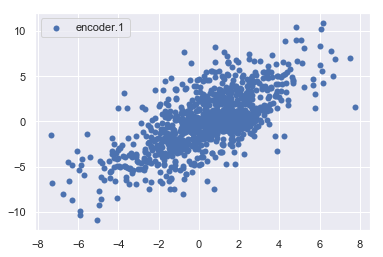

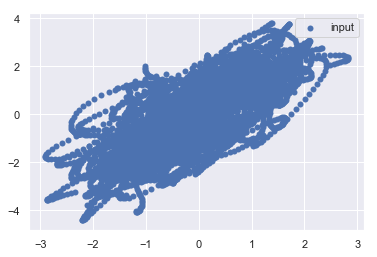

Loss after 40 epochs: 0.00276 (TRAIN) 0.00272 (TEST)


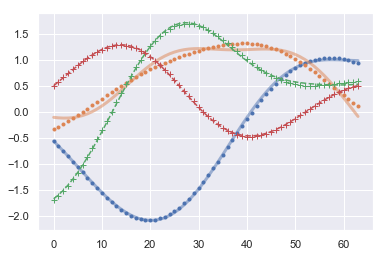

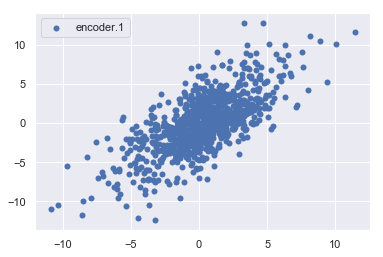

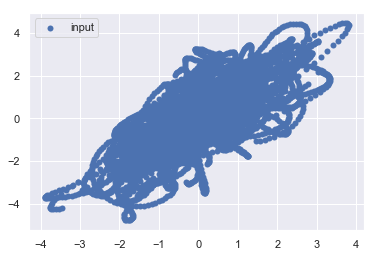

Loss after 60 epochs: 0.00232 (TRAIN) 0.00256 (TEST)


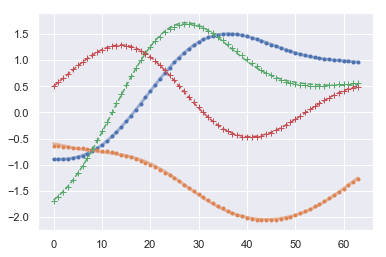

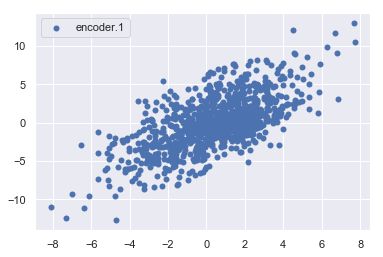

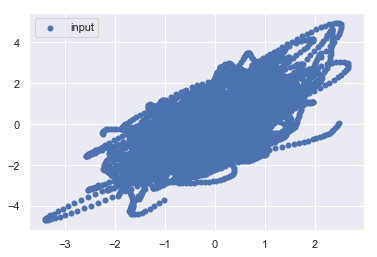

Loss after 80 epochs: 0.00235 (TRAIN) 0.00258 (TEST)


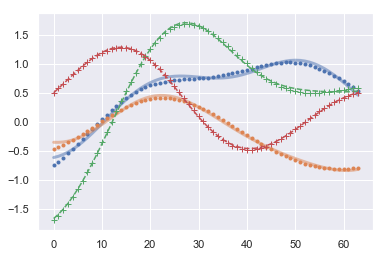

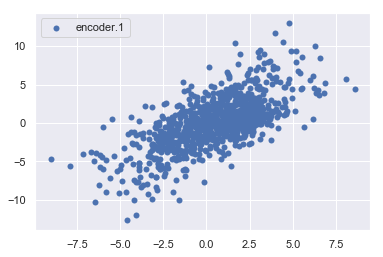

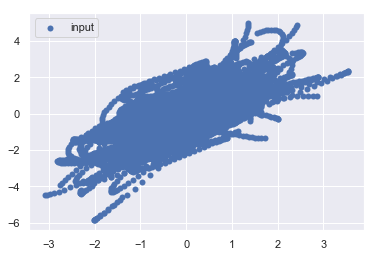

Loss after 100 epochs: 0.00179 (TRAIN) 0.0025 (TEST)


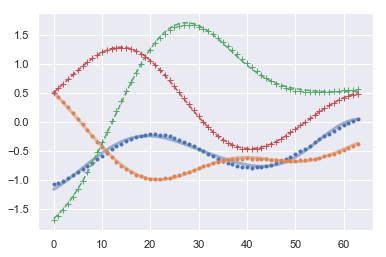

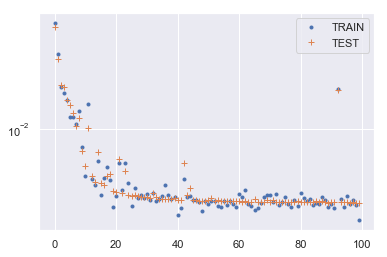

In [343]:
train_losses, test_losses = train_model(
    loader, model, loss, optimizer, n_epochs=100, test_data=torch.Tensor(X_test), report_interval=20)

Recommended lr=0.141.


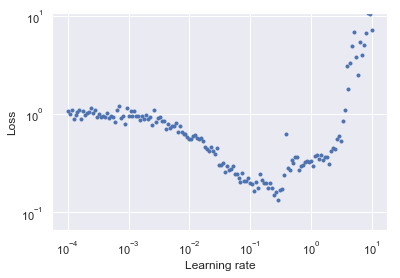

In [354]:
torch.manual_seed(123)
model = EncodeDecode([64, 16, 4], activation=torch.nn.Tanh)
optimizer = lr_scan(loader, model, loss, torch.optim.Adamax, lr_start=1e-4, lr_stop=10)

Training model with 2276 params over 100 epochs of 20000 samples with batch size 128.
registered encoder.1
registered encoder.3
registered decoder.1
registered input


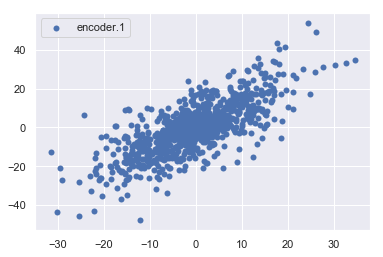

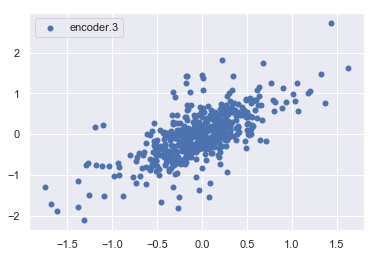

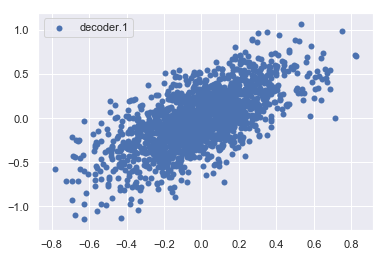

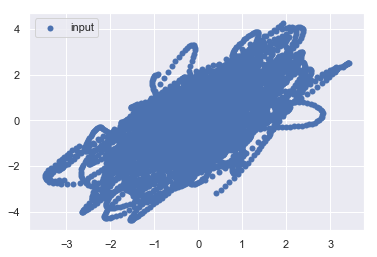

Loss after 20 epochs: 0.0347 (TRAIN) 0.0323 (TEST)


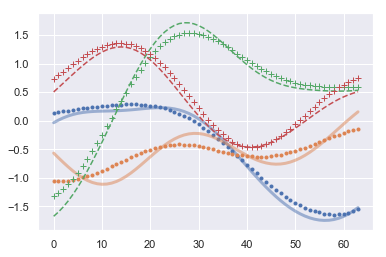

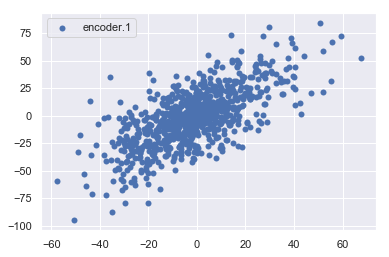

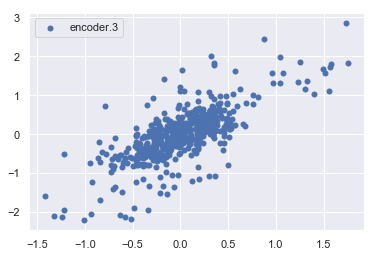

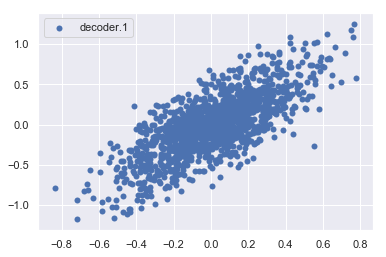

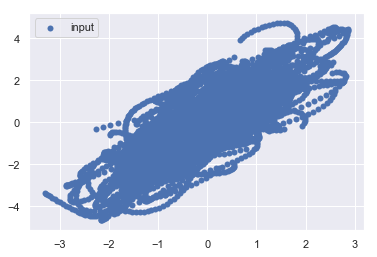

Loss after 40 epochs: 0.0282 (TRAIN) 0.0311 (TEST)


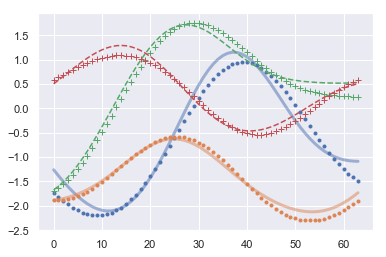

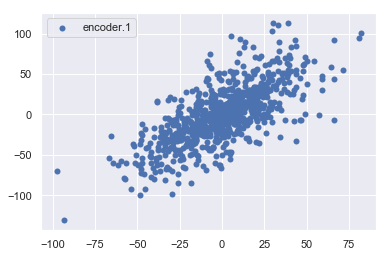

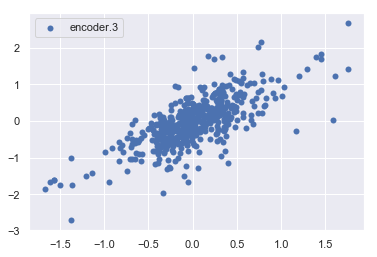

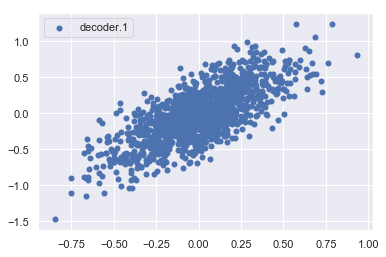

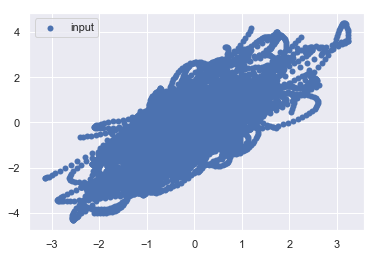

Loss after 60 epochs: 0.0352 (TRAIN) 0.0331 (TEST)


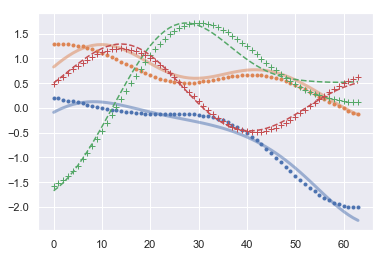

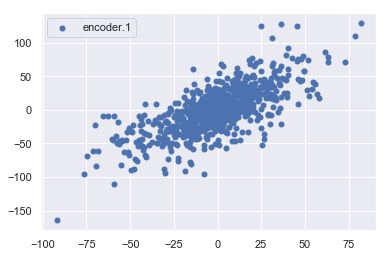

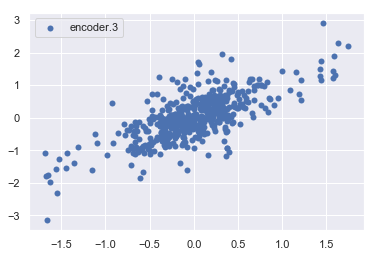

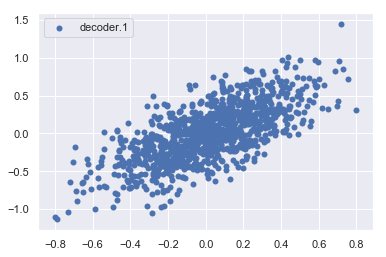

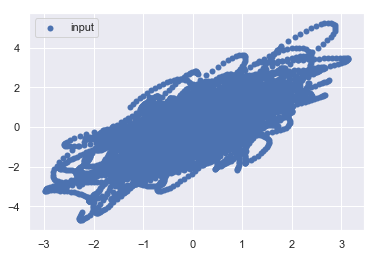

Loss after 80 epochs: 0.0346 (TRAIN) 0.0346 (TEST)


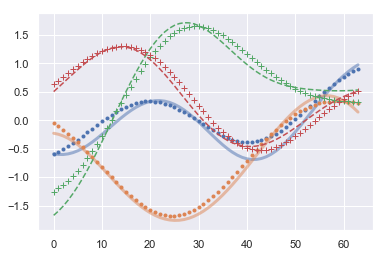

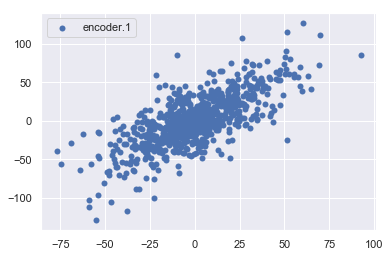

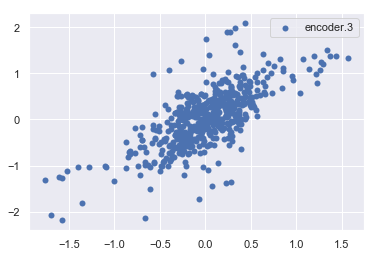

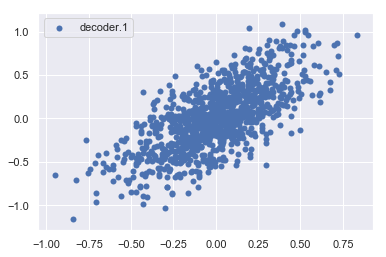

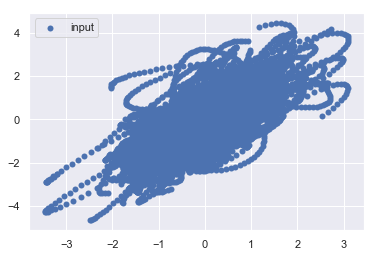

Loss after 100 epochs: 0.0342 (TRAIN) 0.0426 (TEST)


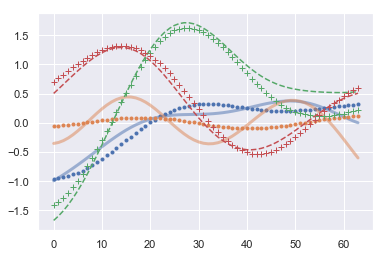

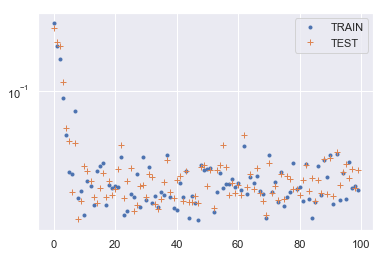

In [355]:
train_losses, test_losses = train_model(
    loader, model, loss, optimizer, n_epochs=100, test_data=torch.Tensor(X_test), report_interval=20)

In [202]:
class ConvEncodeDecode(torch.nn.Module):
    
    def __init__(self, n_input, n_chan=4, activation=torch.nn.ReLU):
        super(ConvEncodeDecode, self).__init__()
        self.n_input = n_input
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1, n_chan, 8, 2), # Lout = 29
            torch.nn.BatchNorm1d(n_chan),
            activation(),
            torch.nn.Conv1d(n_chan, n_chan, 7, 2), # Lout = 12
            torch.nn.BatchNorm1d(n_chan),
            activation(),
            torch.nn.Linear(12, 8 // n_chan),
            activation(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8 // n_chan, 12),
            torch.nn.BatchNorm1d(n_chan),
            activation(),
            torch.nn.ConvTranspose1d(n_chan, n_chan, 7, 2),
            torch.nn.BatchNorm1d(n_chan),
            activation(),
            torch.nn.ConvTranspose1d(n_chan, 1, 8, 2),
        )
        
    def forward(self, fx_in):
        return self.decoder(self.encoder(fx_in.reshape(-1, 1, self.n_input))).reshape(-1, self.n_input)

model has 395 parameters.
Recommended lr=0.194.


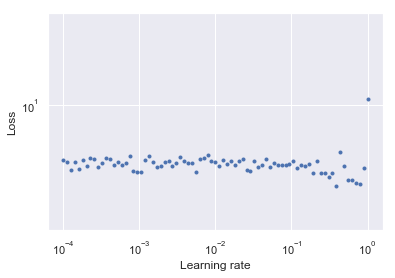

In [205]:
torch.manual_seed(123)
model = ConvEncodeDecode(n_input=64)
print(f'model has {model.get_nparams()} parameters.')
optimizer = lr_scan(loader, model, loss, lr_start=1e-4, lr_stop=1)

Training model with 395 params over 500 epochs of 10000 samples with batch size 128.
Loss after 50 epochs: 0.498 (TRAIN) 0.645 (TEST)


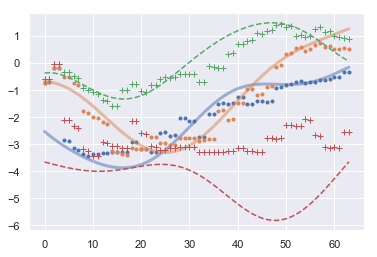

Loss after 100 epochs: 0.75 (TRAIN) 0.941 (TEST)


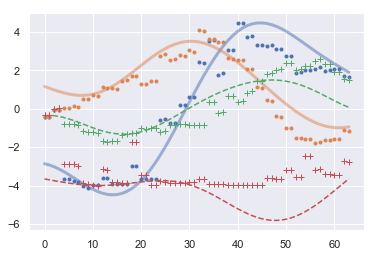

Loss after 150 epochs: 0.639 (TRAIN) 0.866 (TEST)


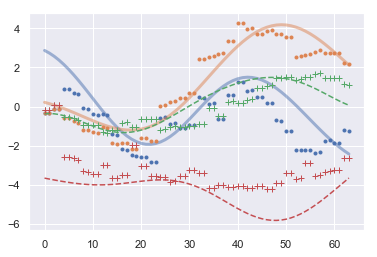

Loss after 200 epochs: 0.653 (TRAIN) 0.477 (TEST)


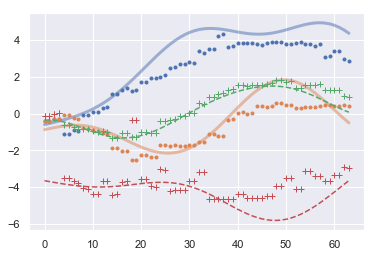

Loss after 250 epochs: 0.774 (TRAIN) 0.554 (TEST)


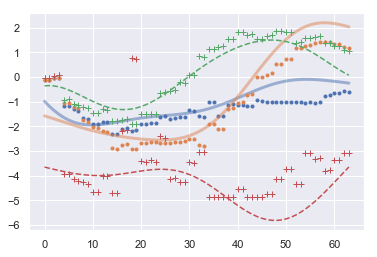

Loss after 300 epochs: 0.866 (TRAIN) 1.25 (TEST)


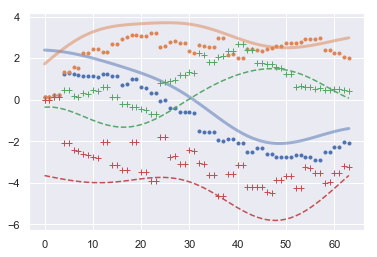

Loss after 350 epochs: 0.786 (TRAIN) 1.32 (TEST)


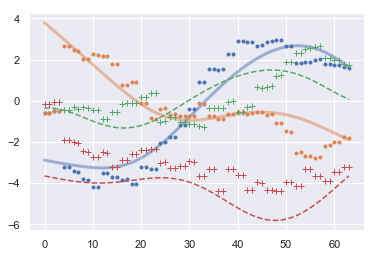

Loss after 400 epochs: 0.573 (TRAIN) 0.539 (TEST)


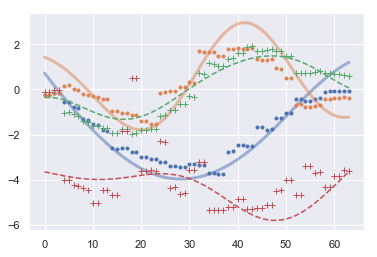

Loss after 450 epochs: 0.324 (TRAIN) 0.435 (TEST)


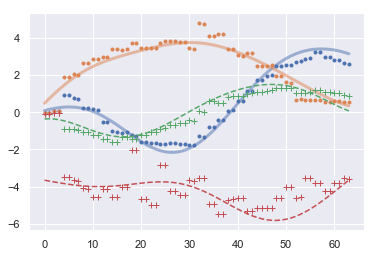

Loss after 500 epochs: 0.462 (TRAIN) 0.591 (TEST)


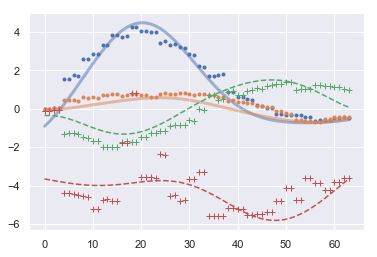

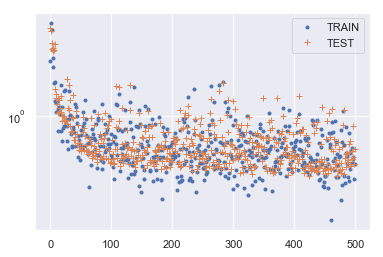

In [206]:
optimizer.set_lr(0.01)
train_losses, test_losses = train_model(
    loader, model, loss, optimizer, n_epochs=500, test_data=torch.Tensor(X_test), report_interval=50)

Bailing out at lr=0.0257 after 48 batches.
Recommended lr=0.00312.


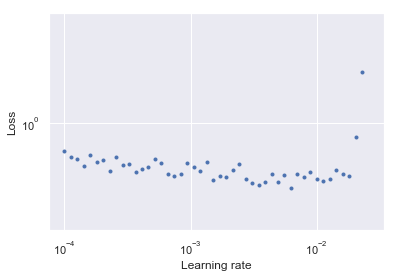

In [207]:
optimizer = lr_scan(loader, model, loss, optimizer, lr_start=1e-4, lr_stop=1)

Training model with 395 params over 500 epochs of 10000 samples with batch size 128.
Loss after 50 epochs: 0.512 (TRAIN) 0.406 (TEST)


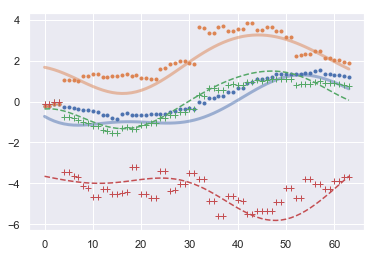

Loss after 100 epochs: 0.737 (TRAIN) 0.369 (TEST)


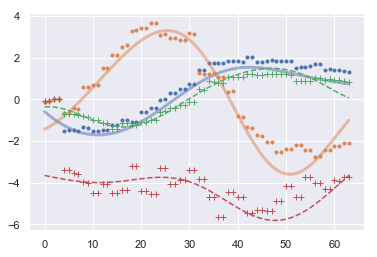

Loss after 150 epochs: 0.686 (TRAIN) 0.368 (TEST)


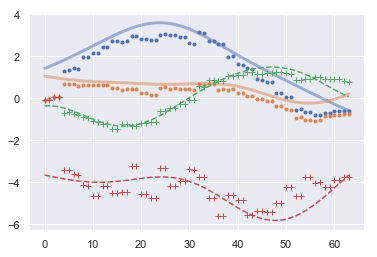

Loss after 200 epochs: 0.595 (TRAIN) 0.407 (TEST)


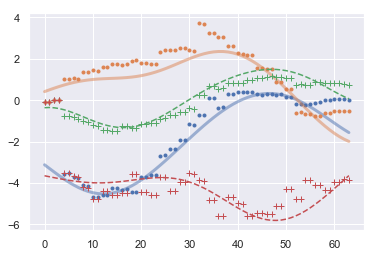

Loss after 250 epochs: 0.465 (TRAIN) 0.379 (TEST)


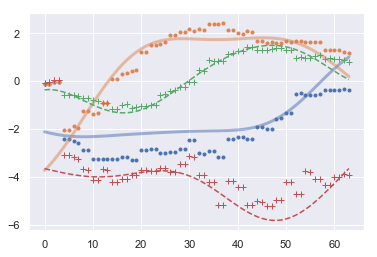

Loss after 300 epochs: 0.324 (TRAIN) 0.368 (TEST)


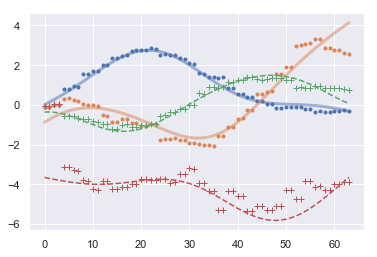

Loss after 350 epochs: 0.683 (TRAIN) 0.382 (TEST)


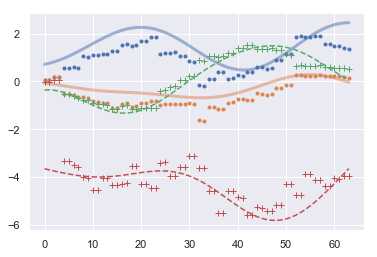

Loss after 400 epochs: 0.689 (TRAIN) 0.374 (TEST)


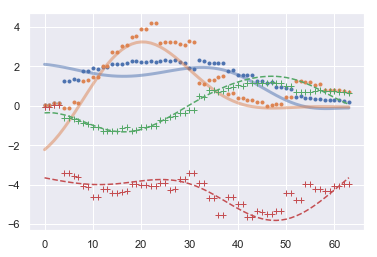

Loss after 450 epochs: 0.304 (TRAIN) 0.38 (TEST)


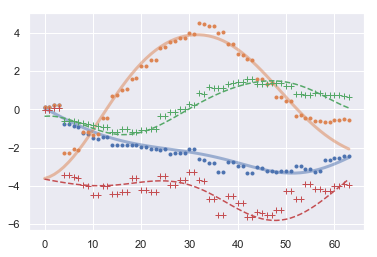

Loss after 500 epochs: 0.344 (TRAIN) 0.369 (TEST)


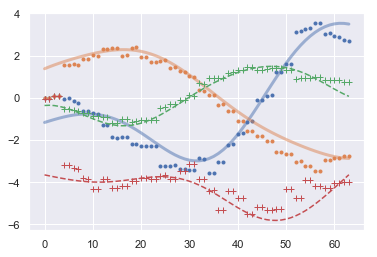

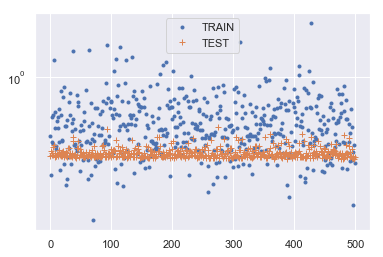

In [208]:
train_losses, test_losses = train_model(
    loader, model, loss, optimizer, n_epochs=500, test_data=torch.Tensor(X_test), report_interval=50)